In [90]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')
plt.rcParams['font.size'] = 14

np.random.seed(123)

import imp;
from IPython.core.display import HTML
css_file = '../my.css';
HTML(open(css_file, "r").read())

### One-way Analysis Of Variance (ANOVA)

One-way ANOVA is a statistical method to test the claim that the means of **two or more** samples $x_i$ with sample size $n_i$ ($i=1 \ldots k$) are equal. The test makes the following assumptions:

- the shape of the population from which the samples are drawn should be normal
- all samples have equal variance
- all samples should be drawn independently

Again there are two hypothesis:

- The null hypothesis $H_0$ states that the means $\overline{x}_i$ with $i=1 \ldots k$ are equal.
- The alternative hypothesis $H_1$ states that the means $\overline{x}_i$ with $i=1 \ldots k$ are not equal.

As with the two sample t-test, the ANOVA test can also be formulated as a test to determine whether two or more independent samples with equal variance are drawn from populations having the same normal distribution. 

One-way ANOVA is a generalization of the two sample t-test (allowing comapre more than two samples). To illustrate this we assume to have access to two gene expression level populations with a difference in mean. We draw one sample with sample size $n=9$ from each population and perform a two sample t-test and a one-way ANOVA test to compute a p-value for the null hypothesis:

In [91]:
n = 9
geneA = np.random.normal(size=n,loc=0.26,scale=0.01)
geneB = np.random.normal(size=n,loc=0.28,scale=0.01)
print "two sample t-test:"
print stats.ttest_ind(geneA,geneB)
print "one-way ANOVA:"
print stats.f_oneway(geneA,geneB)

two sample t-test:
Ttest_indResult(statistic=-4.022327404376181, pvalue=0.0009847119072361069)
one-way ANOVA:
F_onewayResult(statistic=16.179117747995637, pvalue=0.0009847119072361058)


We can see that the p-values computed by both tests are exactly the same. It is the test statistic that is different. ANOVA computes an **F-statistic** that is simply a ratio of two variances. So, where the two sample t-test T-statistic looks at the difference in mean between two samples, the one-way ANOVA F-statistics looks at the **ratio of two variances**. 

Conider a typical ANOVA example in which we want to test the effect of a certain treatment on the expression level of a specific gene. There are three types of treatment: "T1", "T2" and "T3". We have four samples. The first sample contains gene expression levels of mice that did not undergo any treatment. The next three samples contain gene expression levels of mice treated with treatment "T1", "T2" and "T3" respectively. We assume each sample has sample size $n_1=n_2=n_3=n_4=12$.

We want to test if the means of the four samples are equal (i.e. if there is an effect of any of the treatments or not). 

The following code creates these samples such that the means of the populations from which the samples are drawn is indeed equal:

In [92]:
n = 4
sample_control  = np.random.normal(size=n,loc=0.26,scale=0.05)
sample_T1 = np.random.normal(size=n,loc=0.26,scale=0.05)
sample_T2 = np.random.normal(size=n,loc=0.26,scale=0.05)
sample_T3 = np.random.normal(size=n,loc=0.26,scale=0.05)

In ANOVA we don't talk about samples (even though they are samples) but instead we refer to the difference between the samples as a **factor**. For our dataset we can call "treatment" a factor  ((concidering no treatment (control) as a special type of treatment). This factor has four **levels** or **groups**: "control", "T1", "T2" and "T3".

To make this more clear we create a dataset with two columns: column "treatment" (the factor) that sets the type of treatment (the level) of an observation and column "expression_level" that contains the measured gene expression level for an observation (the random variable):

In [93]:
df = pd.DataFrame()
df["treatment"] = ["control"]*n + ["T1"]*n + ["T2"]*n + ["T3"]*n
df["expression_level"] = np.concatenate((sample_control,sample_T1,sample_T2,sample_T3))

Now our dataset looks like this:

In [94]:
df

,treatment,expression_level
0,control,0.310203
1,control,0.279309
2,control,0.296868
3,control,0.334537
4,T1,0.213208
5,T1,0.318791
6,T1,0.197306
7,T1,0.228112
8,T2,0.305355
9,T2,0.188566


To gain insight into the dataset we plot a boxplot for the total gene expression level and then we create four boxplots for the gene expression level in each of the four levels of the factor "treatment":

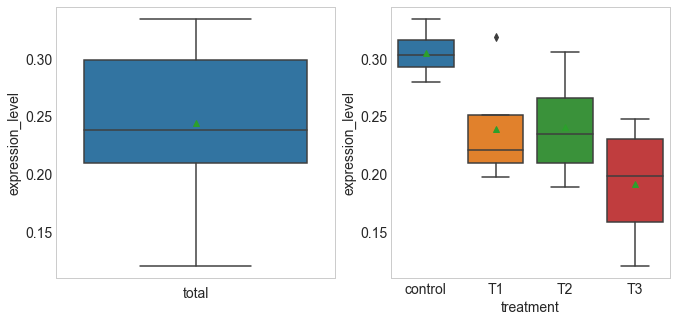

In [95]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
ax = sns.boxplot(y="expression_level",data=df,showmeans=True)
ax.set_xlabel("total")
plt.subplot(1,2,2)
sns.boxplot(x="treatment",y="expression_level",data=df,showmeans=True)
plt.show()

The mean for each distribution is indicated by the green triangle. We see that these sample means differ. But again, is this difference significant? We drew the samples from the same population so we know that it is not.

Let's take a look at the F-statistic for one-way ANOVA. The first variance in the statistic is the variation between the $k=4$ sample means $\overline{x}_i$. This variation is also known as the "**between group variation**" or as the "**explained variance**" as it is the variance in the gene expression that is caused (or can be explained) by the treatment. The variance is computed as what is known as the **treatment sum of squares**:

$$SST=\sum_{i=1}^{k}{n_i(\overline{x}_i - \overline{x}_{total})^2},$$

where $\overline{x}_i$ is the mean of the observations in level $i$ and $\overline{x}_{total}$ is the mean of all observations in the dataset. 

The code below computes the SST for our four samples:

In [96]:
def compute_SST(control,T1,T2,T3):
    mean_total = np.mean(np.concatenate((control,T1,T2,T3)))    
    mean_control = np.mean(control)
    mean_T1 = np.mean(T1)
    mean_T2 = np.mean(T2)
    mean_T3 = np.mean(T3)    
    SST = len(control)*(mean_control-mean_total)**2
    SST += len(T1)*(mean_T1-mean_total)**2
    SST += len(T2)*(mean_T2-mean_total)**2
    SST += len(T3)*(mean_T3-mean_total)**2
    return SST

SST = compute_SST(sample_control,sample_T1,sample_T2,sample_T3)
print "SST = %f" % SST

SST = 0.026385


The second variance in the F-statistic is the variation within the samples, also known as the "**within group variation**" or "**unexplained variance**". This is computed as the **sum of squares of the error**:

$$SSE=\sum_{i=1}^{k}{\sum_{j=1}^{n_i}{(x_{ij} - \overline{x}_i)^2}},$$

where $x_{ij}$ id the $j$th observation in sample $i$. 

The following code computes the SSE:

In [97]:
def compute_SSE(control,T1,T2,T3):
    mean_control = np.mean(control)
    mean_T1 = np.mean(T1)
    mean_T2 = np.mean(T2)
    mean_T3 = np.mean(T3)    
    SSE = np.sum([(y-mean_control)**2 for y in control])
    SSE += np.sum([(y-mean_T1)**2 for y in T1])
    SSE += np.sum([(y-mean_T2)**2 for y in T2])
    SSE += np.sum([(y-mean_T3)**2 for y in T3])    
    return SSE
    
SSE = compute_SSE(sample_control,sample_T1,sample_T2,sample_T3)        
print "SSE = %f" % SSE

SSE = 0.027860


What is important to realize is that we have just partioned the total variance of the expression levels in our dataset into two parts: one part SST caused by the treatment and one part SSE caused by an unknown source.

We can check this. The variance of the expression level in the dataset (not taking treatment into account) is computed by the **total sum of squares**:

$$TSS=\sum_{i=1}^{k}{\sum_{j=1}^{n_i}{(x_{ij} - \overline{x}_{total})^2}}.$$

The following code computes the TTS:

In [98]:
def compute_TSS(control,T1,T2,T3):
    mean_total = np.mean(np.concatenate((control,T1,T2,T3)))    
    TSS = np.sum([(y-mean_total)**2 for y in control])
    TSS += np.sum([(y-mean_total)**2 for y in T1])
    TSS += np.sum([(y-mean_total)**2 for y in T2])
    TSS += np.sum([(y-mean_total)**2 for y in T3])
    return TSS
    
TSS = compute_TSS(sample_control,sample_T1,sample_T2,sample_T3)        
print "TSS = %f" % TSS

TSS = 0.054245


We now have that TSS = SST + SSE:

In [99]:
print SST + SSE

0.0542450013806602


The F-statistic computed by ANOVA is the ratio of SST and SSE (with some variance normalization as we have seen before):

$$F=\frac{SST/(k-1)}{SSE/(n_t-k)},$$

where $n_t$ is total number of observations in the dataset. The F-statistic increases as the SST increases and/or as the SSE decreases. To state this differently: the F-statistic increases as the explained variance gets larger than the unexplained variance. Note that a larger explained variance means a larger effect of the factor on the total variance in the dataset (TSS), i.e. a larger difference between the means of the factor levels.

If the null hypothesis is true then the F-statistic follows an F-distribution with $df_1=k-1$ and $df_2=n_t-k$ degrees of freedom. For our dataset the F-statistic is:

In [100]:
k = 4
N = k*n

F = (SST/(k-1))/(SSE/(N-k))
print F

3.7882309999920465


The Python function to perform one-way ANOVA shows that this is indeed  the correct value and also computes the p-value for the F-statistic:

In [101]:
print stats.f_oneway(sample_control,sample_T1,sample_T2,sample_T3)

F_onewayResult(statistic=3.7882309999920447, pvalue=0.04020957755287628)


There is another Python function for ANOVA that provides more details on the SST and the SSE:

In [102]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('expression_level ~ treatment',
                data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

             sum_sq    df         F   PR(>F)
treatment  0.026385   3.0  3.788231  0.04021
Residual   0.027860  12.0       NaN      NaN


The column "sum_sq" shows the sum of squares SST in row "treatment" and SSE in row "Residual" (the unexplained variance is sometimes also refered to as the **residuals**). The column "df" shows the degrees of freedom for each variance and the column "F" shows the F-statistic. Finally the last column shows the p-value for the factor "treatment". We can see that the values for SST and SSE are the same as what we computed above.

Consider the example above with treatment T2 showing an increased gene expression level:

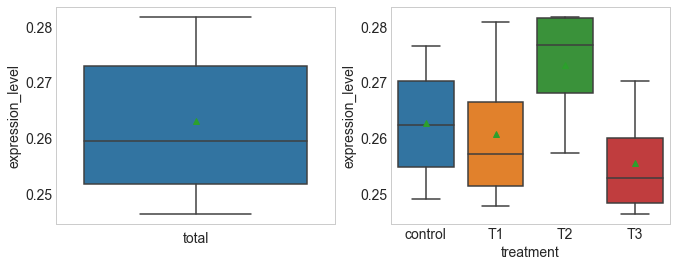

In [107]:
n = 4
sample_control  = np.random.normal(size=n,loc=0.26,scale=0.01)
sample_T1 = np.random.normal(size=n,loc=0.26,scale=0.01)
sample_T2 = np.random.normal(size=n,loc=0.27,scale=0.01)
sample_T3 = np.random.normal(size=n,loc=0.26,scale=0.01)
df = pd.DataFrame()
df["treatment"] = ["control"]*n + ["T1"]*n + ["T2"]*n + ["T3"]*n
df["expression_level"] = np.concatenate((sample_control,sample_T1,sample_T2,sample_T3))
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
ax = sns.boxplot(y="expression_level",data=df,showmeans=True)
ax.set_xlabel("total")
plt.subplot(1,2,2)
sns.boxplot(x="treatment",y="expression_level",data=df,showmeans=True)
plt.show()

If we now perform ANOVA we see that the p-value for treatment is very small and we reject the null hypothesis for $\alpha=0.01$:

In [104]:
mod = ols('expression_level ~ treatment',
                data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

             sum_sq    df         F    PR(>F)
treatment  0.001818   3.0  5.644626  0.002316
Residual   0.004725  44.0       NaN       NaN


The ANOVA says that the means of the four samples are not equal. But we do not know which mean(s) differ(s). Other statistical tests such as the least significant difference test can gain more insight into which level(s) differ(s). This test is only used when the null hypothesis is rejected as a result of your hypothesis test results.

Also, we could perform several pair-wise two sample t-tests. Then why perform one-way ANOVA if we can just do all pair-wise two-sample comparisons? The answer lies again in the power of the test. An ANOVA analysis is more likely to correctly reject the null hypothesis than any of the more specific pair-wise t-test, i.e. ANOVA has higher power.

### two-way ANOVA

In our gene expression dataset we called the treatment a factor. A factor has two or more levels. In our dataset there are $k_t=4$ levels: "control", "T1", "T2" and "T3". In two-way ANOVA there are **two factors**, each with two or more levels.

Let's add another factor to our dataset. Suppose we take the sex of a model mouse into account. We add (randomly) a second factor "sex" to the dataset with $k_s=2$ levels: "female" and "male":

In [108]:
df["sex"] = ["female" if x%2==0 else "male" for x in range(k*n)]
df = df[["treatment","sex","expression_level"]].sort_values(["treatment","sex"])

This is what this dataset looks like:

In [110]:
df[["treatment","expression_level"]].sort_index()

,treatment,expression_level
0,control,0.276610
1,control,0.268073
2,control,0.256852
3,control,0.249141
4,T1,0.252675
5,T1,0.247875
6,T1,0.280871
7,T1,0.261644
8,T2,0.281502
9,T2,0.257326


For each of the $k_t \times k_s = 8$ level combinations the dataset contains $r=6$ observations.

We can plot this dataset as boxplots for each factor level and for each combination of levels between the factors (remember that treatment "T2" has an increased expression level in our dataset):

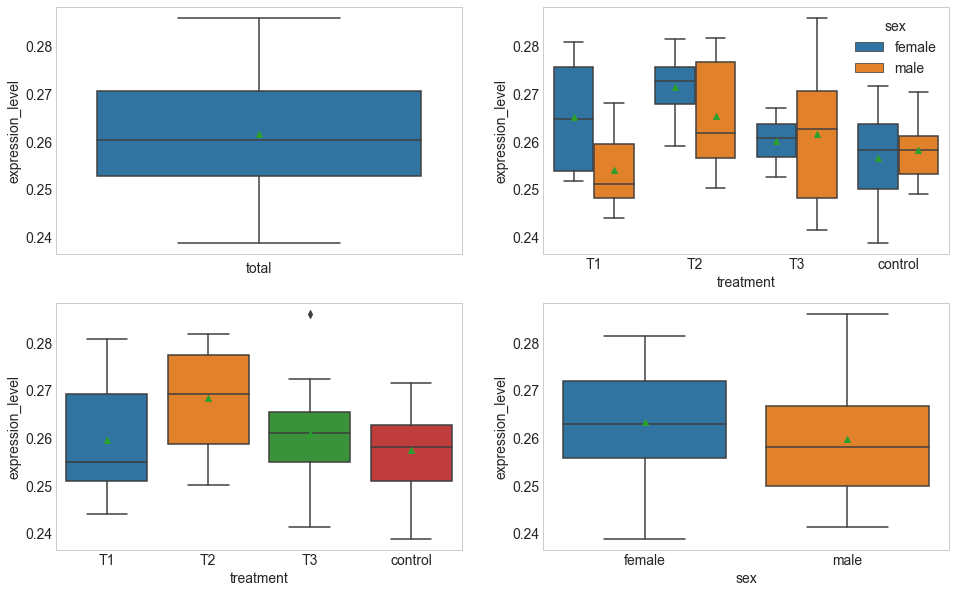

In [62]:
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
ax = sns.boxplot(y="expression_level",data=df,showmeans=True)
ax.set_xlabel("total")
plt.subplot(2,2,2)
ax = sns.boxplot(x="treatment",y="expression_level",hue="sex",data=df,showmeans=True)
plt.subplot(2,2,3)
ax = sns.boxplot(x="treatment",y="expression_level",data=df,showmeans=True)
plt.subplot(2,2,4)
ax = sns.boxplot(x="sex",y="expression_level",data=df,showmeans=True)
plt.show()

We can perform a one-way ANOVA for the factor "treatment" again (so not taking the factor "sex" into account):

In [63]:
mod = ols('expression_level ~ treatment',
                data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

             sum_sq    df         F    PR(>F)
treatment  0.000830   3.0  2.206083  0.100765
Residual   0.005519  44.0       NaN       NaN


At $\alpha=0.01$ the test correctly rejects the null hypothesis. 

Also, we can perform a one-way ANOVA for the factor "sex" (so not taking the factor "treatment" into account):

In [64]:
mod = ols('expression_level ~ sex',
                data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

            sum_sq    df        F    PR(>F)
sex       0.000157   1.0  1.16412  0.286238
Residual  0.006192  46.0      NaN       NaN


At $\alpha=0.01$ the test correctly accepts the null hypothesis as we assigned the levels for factor "sex" randomly.

In two-way ANOVA both factors are taken into account when computing the F-statistic. Similar to one-way ANOVA the total variance $TSS$ of the gene expresion level is partitioned into the variance $SS_{treatment}$ caused by the factor "treatment", the variance $SS_{sex}$ caused by the factor "sex" and the variance $SSE$ caused by an unknown source:

$$TSS=SS_{treatment}+SS_{sex}+SSE.$$

So, what does this mean? 

First we perform a two-way ANOVA on our dataset. We can do this in Python as follows:

In [65]:
mod = ols('expression_level ~ treatment + sex',
                data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

             sum_sq    df         F    PR(>F)
treatment  0.000830   3.0  2.218952  0.099638
sex        0.000157   1.0  1.256663  0.268505
Residual   0.005362  43.0       NaN       NaN


Notice how a row is added for the factor "sex". We have two p-values: one for factor "treatment" and one for factor "sex". At $\alpha=0.01$ only factor "treatment" shows a difference in mean for one or more of the levels.

Now we make a drastic change in our dataset. We increase the gene expression level for male mice consistently with 0.05:

In [66]:
df_male = df[df.sex=="male"]
df_female = df[df.sex=="female"]
df_male.loc[:,"expression_level"] = df_male.loc[:,"expression_level"] + 0.05
df2 = pd.concat([df_male,df_female])

If we plot our dataset now we get:

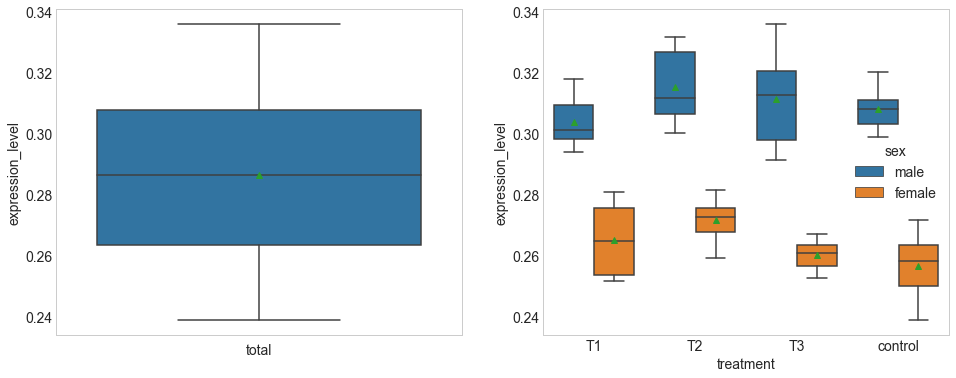

In [67]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
ax = sns.boxplot(y="expression_level",hue="treatment",data=df2,showmeans=True)
ax.set_xlabel("total")
plt.subplot(1,2,2)
sns.boxplot(x="treatment",y="expression_level",hue="sex",data=df2,showmeans=True)
plt.show()

The first thing we notice is that the total variance (the variance for all the observations (not taking the two factors into account)) is much larger than the variance of the eight factor level combinations individually. This large variance is caused by the fact that male mice have much higher geneA expression levels than female mice.

When we perform one-way ANOVA for the factor "treatment" then the factor "sex" (which we don't take into account when doing a one-way ANOVA on "treatment") increases the variance in the four levels of factor "treatment". We can plot this as follows:

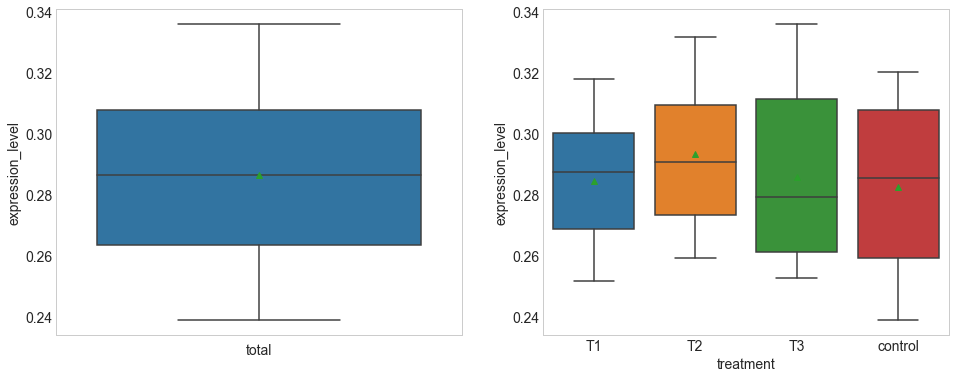

In [68]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
ax = sns.boxplot(y="expression_level",hue="treatment",data=df2,showmeans=True)
ax.set_xlabel("total")
plt.subplot(1,2,2)
sns.boxplot(x="treatment",y="expression_level",data=df2,showmeans=True)
plt.show()

When we perform a one-way ANOVA we get:

In [69]:
mod = ols('expression_level ~ treatment',
                data=df2).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

             sum_sq    df         F    PR(>F)
treatment  0.000830   3.0  0.390449  0.760446
Residual   0.031182  44.0       NaN       NaN


So, even though we know that level "T2" in factor "treatment" does have an effect on the gene expression (increased expression level), it is not detected by the hypothesis test. This is because of the large variance caused by the factor "sex". We can see this clearly in the following boxplots showing expression levels for the factor "sex":

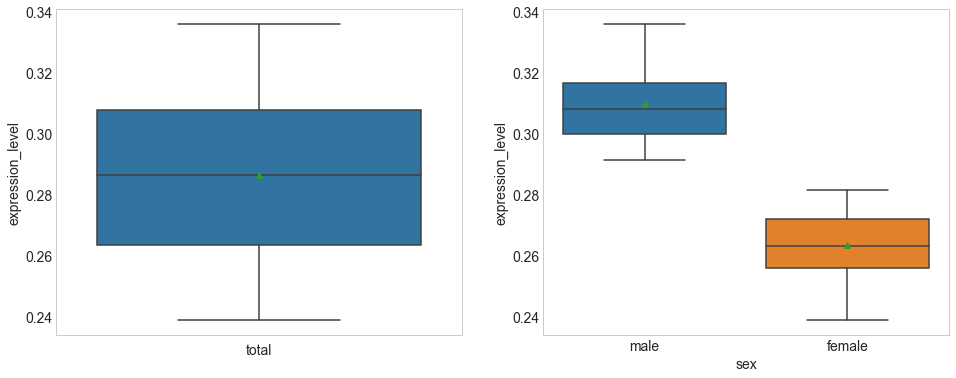

In [70]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
ax = sns.boxplot(y="expression_level",hue="treatment",data=df2,showmeans=True)
ax.set_xlabel("total")
plt.subplot(1,2,2)
sns.boxplot(x="sex",y="expression_level",data=df2,showmeans=True)
plt.show()

We can see how most of the total variance can be explained by the factor "sex". The one-way ANOVA confirms this:

In [71]:
print
mod = ols('expression_level ~ sex',
                data=df2).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table


            sum_sq    df           F        PR(>F)
sex       0.025820   1.0  191.807082  5.046573e-18
Residual  0.006192  46.0         NaN           NaN


We do obtain a very small p-value.

Let's compute the two-way ANOVA p-values:

In [72]:
mod = ols('expression_level ~ treatment + sex',
                data=df2).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

             sum_sq    df           F        PR(>F)
treatment  0.000830   3.0    2.218952  9.963759e-02
sex        0.025820   1.0  207.055139  4.824759e-18
Residual   0.005362  43.0         NaN           NaN


Now we can see that, as expected, both p-values are below $\alpha=0.01$. This is because in two-way ANOVA there are two assignable sources of variation ("treatment" and "sex" in our example) and **this reduces error variation** thereby giving the test more power. The main difference with one-way ANOVA is the computation of the sum of squares of the error SSE which is computed in two-way ANOVA as

$$SSE=\sum_{l=1}^{r}{\sum_{j=1}^{k_s}{\sum_{i=1}^{k_t}{(x_{ijl} - \overline{x}_{ij})^2}}},$$

where $x_{ijl}$ is the $l$th observation (of a total of $r$ observations) in level $i$ for factor "treatment" and level $j$ for factor "sex".

Let's again compare the one-way ANOVA on the factor "treatment" with the two-way ANOVA on "treatment" and "factor": 

In [73]:
print "one-way ANOVA on treatment"
mod = ols('expression_level ~ treatment',
                data=df2).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

print
print "two-way ANOVA on treatment and sex"
mod = ols('expression_level ~ treatment + sex',
                data=df2).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

one-way ANOVA on treatment
             sum_sq    df         F    PR(>F)
treatment  0.000830   3.0  0.390449  0.760446
Residual   0.031182  44.0       NaN       NaN

two-way ANOVA on treatment and sex
             sum_sq    df           F        PR(>F)
treatment  0.000830   3.0    2.218952  9.963759e-02
sex        0.025820   1.0  207.055139  4.824759e-18
Residual   0.005362  43.0         NaN           NaN


We can see that $SS_{treatment}$ is the same in both tests. However $SSE$ (the residuals) is much smaller for the two-way ANOVA F-statistic. This is because in the computation of $SSE$ the variation caused by both factors is taken into account. Since $SSE$ is in the denominator of the F-statistic, a smaller $SSE$ means a larger F-statistic which in turn implies a smaller p-value.

As in two-way ANOVA there are two factors we have to take into account that there could be an **interaction** between these factors. If this is the case then we should be very careful with the conclusions we make about the individual factors. In two-way ANOVA with interaction the total variance is partitoned as 

$$TSS=SS_{treatment}+SS_{sex}+SS_{treatment:sex}+SSE,$$

where $SS_{treatment:sex}$ is the variance caused by the (potential) interaction of the two factors "treatment" and "sex". 

Let's check for an interaction effect in our dataset. We can do this in Python as follows:

In [74]:
print "two-way ANOVA with interaction term:"
mod = ols('expression_level ~ treatment * sex',
                data=df2).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

two-way ANOVA with interaction term:
                 sum_sq    df           F        PR(>F)
treatment      0.000830   3.0    2.208316  1.020464e-01
sex            0.025820   1.0  206.062703  2.264735e-17
treatment:sex  0.000350   3.0    0.931299  4.345034e-01
Residual       0.005012  40.0         NaN           NaN


At $\alpha=0.01$ we conclude that there is no significant interation between the two factors in our dataset.

Now consider the following example where there is a clear interaction. The factor "treatment" has just $k_t=2$ levels: "T1" and "T2" and we have again a factor "sex" with also $k_s=2$ levels: "female" and "male". For level "T1" the mean female mouse gene expression level is higher than for males. However, for level "T2" the mean female mouse gene expression level is lower than for males. Also, there is a difference between the means of levels "T1" and "T2" as well as there is a difference between the means of levels "male" and "female": 

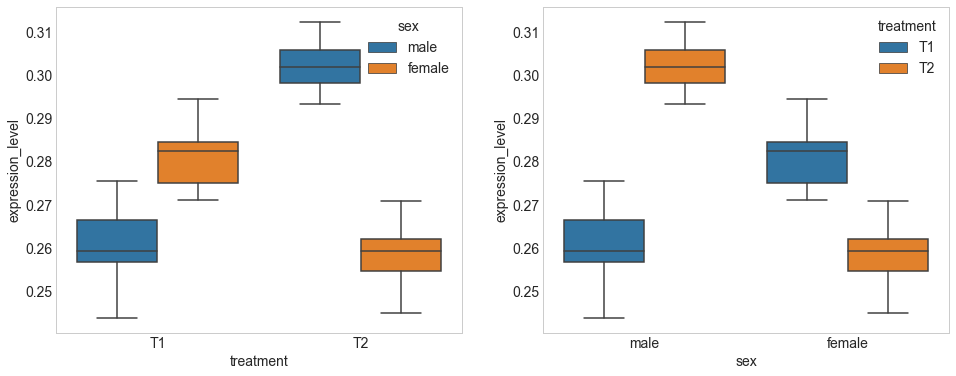

In [75]:
r = 12
group_T1_male  = np.random.normal(size=r,loc=0.26,scale=0.008)
group_T1_female  = np.random.normal(size=r,loc=0.28,scale=0.008)
group_T2_male  = np.random.normal(size=r,loc=0.30,scale=0.008)
group_T2_female  = np.random.normal(size=r,loc=0.26,scale=0.008)
df3 = pd.DataFrame()
df3["treatment"] = ["T1"]*2*r + ["T2"]*2*r
df3["sex"] = ["male"]*r + ["female"]*r + ["male"]*r + ["female"]*r
df3["expression_level"] = np.concatenate((group_T1_male,group_T1_female,group_T2_male,group_T2_female))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(x="treatment",y="expression_level",hue="sex",data=df3)
plt.subplot(1,2,2)
sns.boxplot(x="sex",y="expression_level",hue="treatment",data=df3)
plt.show()

First we compute the one-way ANOVA for each factor:

In [76]:
print "one-way ANOVA for treatment:"
mod = ols('expression_level ~ treatment',
                data=df3).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

print
print "one-way ANOVA for sex:"
mod = ols('expression_level ~ sex',
                data=df3).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

one-way ANOVA for treatment:
             sum_sq    df         F    PR(>F)
treatment  0.001189   1.0  3.261662  0.077463
Residual   0.016775  46.0       NaN       NaN

one-way ANOVA for sex:
            sum_sq    df         F    PR(>F)
sex       0.001797   1.0  5.112435  0.028529
Residual  0.016167  46.0       NaN       NaN


At $\alpha=0.01$ both null hypothesis are accepted. Now we perform a two-way ANOVA without taking the interaction into account:

In [77]:
print "two-way ANOVA without interaction term:"
mod = ols('expression_level ~ treatment + sex',
                data=df3).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

two-way ANOVA without interaction term:
             sum_sq    df         F    PR(>F)
treatment  0.001189   1.0  3.573538  0.065157
sex        0.001797   1.0  5.398458  0.024731
Residual   0.014978  45.0       NaN       NaN


Again both null hypothesis are accepted. This is incorrect as we know that both "treatment" and "sex" have a significant effect on the gene expression level. The problem is that both factors even each other out as we will see in the next plots. The two-way ANOVA that takes an interaction between the factors into account gives:

In [78]:
print "two-way ANOVA with interaction term:"
mod = ols('expression_level ~ treatment * sex',
                data=df3).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

two-way ANOVA with interaction term:
                 sum_sq    df           F        PR(>F)
treatment      0.001189   1.0   21.445085  3.228798e-05
sex            0.001797   1.0   32.396576  9.557451e-07
treatment:sex  0.012538   1.0  226.048571  6.008752e-19
Residual       0.002440  44.0         NaN           NaN


At $\alpha=0.01$ we see that this time both null hypothesis are correctly rejected. We also see a third p-value (for the interaction "treatment:sex" that shows that there is indeed a significant interaction between the factors.

To better illustrate the effect of the interaction we can plot the distribution of expression levels between the levels for each factor:

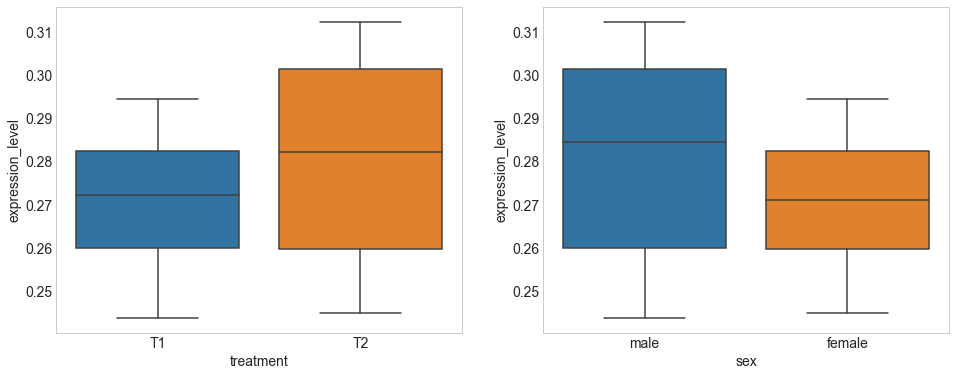

In [79]:
#because of interaction no difference is observed
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(x="treatment",y="expression_level",data=df3)
plt.subplot(1,2,2)
sns.boxplot(x="sex",y="expression_level",data=df3)
plt.show()

Notice how because of the interaction we observe no clear difference between the means of the levels in a factor. 

### Power analysis

We have seen that the power of a hypothesis test is defined as the probability of correctly rejecting the null hypothesis in case the alternative hypothesis is true. In power analysis the power is defined as $1-\beta$ where $\beta$ is the probability of accepting the null hypothesis even though the alternative hypothesis is true.

When preparing a statistical analysis it is good practice to estimate the sample size required to find the effect of interest if it exists. The "effect of interest" is known as the **effect size**. 

Suppose we want to test if there is a difference between the mean expression level of two genes (geneA and geneB). We want to design a statistical experiment that is able to detect (if it exists) a minimum 0.02 in expression difference between the expression level of both genes. This "minimum 0.02 difference" is the **minimum** effect size we want to be able to detect (again, if it exists). 

Let's illustrate this. We know that the power of a two sample t-test (and all other hypothesis tests) depends on the variance of the (normal) population from which the sample(s) are drawn. We fix the sample size $n$, the effect size (noted as variable  `diff` in the code below) and the significance level $\alpha$. Next we vary the variance (or standard deviation $\sigma$) of the population from which the samples are drawn and estimate the power of the two sample t-test by repeating it $m=1000$ times:    

In [80]:
m = 1000
alpha = 0.01
n = 9
diff = 0.02
for sigma in [0.01,0.015,0.02,0.025,0.03,0.04,0.05]:
    power = 0.
    for i in range(m):
        geneA = np.random.normal(size=n,loc=0.26,scale=sigma)
        geneB = np.random.normal(size=n,loc=0.26+diff,scale=sigma)
        pvalue = stats.ttest_ind(geneA,geneB).pvalue
        if pvalue < alpha:
            power += 1.
    print "sample size: %i / effect size: %.2f / population std: %.3f / power: %.2f" % \ 
    (n,diff,sigma,power/m)

sample size: 9 / effect size: 0.02 / population std: 0.010 / power: 0.88
sample size: 9 / effect size: 0.02 / population std: 0.015 / power: 0.52
sample size: 9 / effect size: 0.02 / population std: 0.020 / power: 0.26
sample size: 9 / effect size: 0.02 / population std: 0.025 / power: 0.13
sample size: 9 / effect size: 0.02 / population std: 0.030 / power: 0.10
sample size: 9 / effect size: 0.02 / population std: 0.040 / power: 0.06
sample size: 9 / effect size: 0.02 / population std: 0.050 / power: 0.03


We see that the power of the two sample t-test deceases as the variance of the population increases. We also know that the power of a two sample t-test (and all other hypothesis tests) depends on the sample size $n$. We fix the population variance, the effect size and the significance level $\alpha$. Next we vary the samples size $n$ and compute the power of the two sample t-test by repeating it 1000 times:   

In [81]:
sigma = 0.01
diff = 0.02
for n in range(2,15):
    power = 0.
    for i in range(m):
        geneA = np.random.normal(size=n,loc=0.26,scale=sigma)
        geneB = np.random.normal(size=n,loc=0.26+diff,scale=sigma)
        pvalue = stats.ttest_ind(geneA,geneB).pvalue
        if pvalue < alpha:
            power += 1.
    print "sample size: %i / effect size: %.2f / population std: %.3f / power: %.2f" % \
    (n,diff,sigma,power/m)

sample size: 2 / effect size: 0.02 / population std: 0.010 / power: 0.05
sample size: 3 / effect size: 0.02 / population std: 0.010 / power: 0.16
sample size: 4 / effect size: 0.02 / population std: 0.010 / power: 0.33
sample size: 5 / effect size: 0.02 / population std: 0.010 / power: 0.47
sample size: 6 / effect size: 0.02 / population std: 0.010 / power: 0.65
sample size: 7 / effect size: 0.02 / population std: 0.010 / power: 0.73
sample size: 8 / effect size: 0.02 / population std: 0.010 / power: 0.84
sample size: 9 / effect size: 0.02 / population std: 0.010 / power: 0.91
sample size: 10 / effect size: 0.02 / population std: 0.010 / power: 0.93
sample size: 11 / effect size: 0.02 / population std: 0.010 / power: 0.96
sample size: 12 / effect size: 0.02 / population std: 0.010 / power: 0.98
sample size: 13 / effect size: 0.02 / population std: 0.010 / power: 0.99
sample size: 14 / effect size: 0.02 / population std: 0.010 / power: 0.99


We see that the power of the two sample t-test increases as the sample size increases. Finally the power of a two sample t-test (and all other hypothesis tests) also depends on the minimum effect size we hope to detect if it exists. We fix the population variance, the sample size and the significance level $\alpha$. Next we vary the effect size (variable `diff` in the code below) and compute the power of the two sample t-test by repeating it 1000 times: 

In [82]:
sigma = 0.01
n= 9
for diff in [0.001,0.005,0.01,0.02,0.03,0.04]:
    power = 0.
    for i in range(m):
        geneA = np.random.normal(size=n,loc=0.26,scale=sigma)
        geneB = np.random.normal(size=n,loc=0.26+diff,scale=sigma)
        pvalue = stats.ttest_ind(geneA,geneB).pvalue
        if pvalue < alpha:
            power += 1.
    print "sample size: %i / effect size: %.2f / population std: %.3f / power: %.2f" % \ 
    (n,diff,sigma,power/m)

sample size: 9 / effect size: 0.00 / population std: 0.010 / power: 0.01
sample size: 9 / effect size: 0.01 / population std: 0.010 / power: 0.06
sample size: 9 / effect size: 0.01 / population std: 0.010 / power: 0.24
sample size: 9 / effect size: 0.02 / population std: 0.010 / power: 0.89
sample size: 9 / effect size: 0.03 / population std: 0.010 / power: 1.00
sample size: 9 / effect size: 0.04 / population std: 0.010 / power: 1.00


We see that the power of the two sample t-test increases as the effect size increases, which makes sense.

So the power of a hypothesis test depends on these four numbers: 

- the effect size
- the population variance
- the sample size
- the significance level

This means that when we fix the expected power of a test, the minimum effect size, the population variance and the significance level we can compute the minimum sample size $n$ required to achieve this expected power.

In Python we can compute the minimum sample size required for a certain minimum statistical power as follows:

In [83]:
import statsmodels.stats.power as smp
sigma = 0.01
diff = 0.02
for power in [0.99,0.95,0.9,0.8]:    
    print "Minimum sample size required for power = %f: %f" \
       % (power,smp.TTestIndPower().solve_power(diff/sigma, power=power, alpha=alpha, alternative='two-sided'))

Minimum sample size required for power = 0.990000: 13.805334
Minimum sample size required for power = 0.950000: 10.710971
Minimum sample size required for power = 0.900000: 9.251530
Minimum sample size required for power = 0.800000: 7.660540


In this code the population variance is taken into account by dividing the effect size (variable `diff`) by the expected standard deviation of the population(s) from which the samples are drawn.

According to the power analysis, if we expect a minimum power of 95% then we need to draw at least $n=10.710971=11$ observations in each sample. We can verify this with the code we used above for varying the sample size and computing the power:

In [84]:
n = 11
power = 0.
for i in range(m):
    geneA = np.random.normal(size=n,loc=0.26,scale=0.01)
    geneB = np.random.normal(size=n,loc=0.26+diff,scale=0.01)
    pvalue = stats.ttest_ind(geneA,geneB).pvalue
    if pvalue < alpha:
        power += 1.
print "Power for sample size %i, mean difference %f and population sigma %f: %f" % \ 
(n,diff,sigma,power/(float(m)))

Power for sample size 11, mean difference 0.020000 and population sigma 0.010000: 0.956000


We can see that our estimations are indeed correct. 

One problem with a power analysis is that the variance of the population needs to be known, while in most cases this information is not available. Typical practice is to find an estimate for the variance in the scientific literature or perform a "pilot" experiment with small sample size to estimate the population variance from this small sample.

In the design of a statistical study it is important to consider the trade-off between the power of the hypothesis test and the sample size of the study. We can see this by computing the power of our two sample t-test for different sample sizes:

In [85]:
df = []
for n in range(2,24):
    power = smp.TTestIndPower().solve_power(diff/sigma, nobs1=n, alpha=alpha, alternative='two-sided')
    print "Power for sample size %i: %f" % (n,power)
    df.append([n,power])
df = pd.DataFrame(df,columns=["sample size","power"])

Power for sample size 2: 0.048628
Power for sample size 3: 0.156856
Power for sample size 4: 0.313033
Power for sample size 5: 0.476935
Power for sample size 6: 0.622611
Power for sample size 7: 0.739367
Power for sample size 8: 0.826419
Power for sample size 9: 0.887894
Power for sample size 10: 0.929485
Power for sample size 11: 0.956656
Power for sample size 12: 0.973892
Power for sample size 13: 0.984556
Power for sample size 14: 0.991011
Power for sample size 15: 0.994844
Power for sample size 16: 0.997082
Power for sample size 17: 0.998368
Power for sample size 18: 0.999098
Power for sample size 19: 0.999506
Power for sample size 20: 0.999732
Power for sample size 21: 0.999856
Power for sample size 22: 0.999923
Power for sample size 23: 0.999959


If we plot the power against the sample size we get:

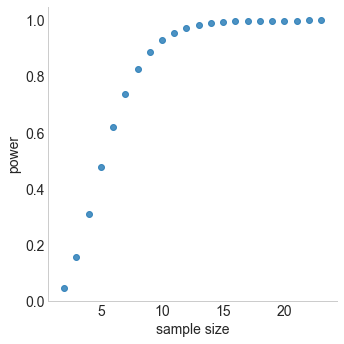

In [86]:
sns.lmplot(x="sample size",y="power",data=df,fit_reg=False)
plt.show()









This plot shows how for small sample sizes adding one more sample significantly increases the power of our test. From the moment we have ten observations in each level we see that the added power decreases exponentially.